# Batch Normalization – Lesson

1. [What is it?](#theory)
2. [What are it's benefits?](#benefits)
3. [How do we add it to a network?](#implementation_1)
4. [Let's see it work!](#demos)
5. [What are you hiding?](#implementation_2)

# What is Batch Normalization?<a id='theory'></a>

Batch normalization was introduced in Sergey Ioffe's and Christian Szegedy's 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). The idea is that, instead of just normalizing the inputs to the network, we normalize the inputs to _layers within_ the network. It's called "batch" normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current mini-batch.

Why might this help? Well, we know that normalizing the inputs to a _network_ helps the network learn. But a network is a series of layers, where the output of one layer becomes the input to another. That means we can think of any layer in a neural network as the _first_ layer of a smaller network.

For example, imagine a 3 layer network. Instead of just thinking of it as a single network with inputs, layers, and outputs, think of the output of layer 1 as the input to a two layer network. This two layer network would consist of layers 2 and 3 in our original network. 

Likewise, the output of layer 2 can be thought of as the input to a single layer network, consisting only of layer 3.

When you think of it like that - as a series of neural networks feeding into each other - then it's easy to imagine how normalizing the inputs to each layer would help. It's just like normalizing the inputs to any other neural network, but you're doing it at every layer (sub-network).

Beyond the intuitive reasons, there are good mathematical reasons why it helps the network learn better, too. It helps combat what the authors call _internal covariate shift_. This discussion is best handled [in the paper](https://arxiv.org/pdf/1502.03167.pdf) and in [Deep Learning](http://www.deeplearningbook.org) a book you can read online written by Ian Goodfellow, Yoshua Bengio, and Aaron Courville. Specifically, check out the batch normalization section of [Chapter 8: Optimization for Training Deep Models](http://www.deeplearningbook.org/contents/optimization.html).

# Benefits of Batch Normalization<a id="benefits"></a>

Batch normalization optimizes network training. It has been shown to have several benefits:
1. **Networks train faster** – Each training _iteration_ will actually be slower because of the extra calculations during the forward pass and the additional hyperparameters to train during back propagation. However, it should converge much more quickly, so training should be faster overall. 
2. **Allows higher learning rates** – Gradient descent usually requires small learning rates for the network to converge. And as networks get deeper, their gradients get smaller during back propagation so they require even more iterations. Using batch normalization allows us to use much higher learning rates, which further increases the speed at which networks train. 
3. **Makes weights easier to initialize** – Weight initialization can be difficult, and it's even more difficult when creating deeper networks. Batch normalization seems to allow us to be much less careful about choosing our initial starting weights.  
4. **Makes more activation functions viable** – Some activation functions do not work well in some situations. Sigmoids lose their gradient pretty quickly, which means they can't be used in deep networks. And ReLUs often die out during training, where they stop learning completely, so we need to be careful about the range of values fed into them. Because batch normalization regulates the values going into each activation function, non-linearlities that don't seem to work well in deep networks actually become viable again.  
5. **Simplifies the creation of deeper networks** – Because of the first 4 items listed above, it is easier to build and faster to train deeper neural networks when using batch normalization. And it's been shown that deeper networks generally produce better results, so that's great.
6. **Provides a bit of regularlization** – Batch normalization adds a little noise to your network. In some cases, such as in Inception modules, batch normalization has been shown to work as well as dropout. But in general, consider batch normalization as a bit of extra regularization, possibly allowing you to reduce some of the dropout you might add to a network. 
7. **May give better results overall** – Some tests seem to show batch normalization actually improves the training results. However, it's really an optimization to help train faster, so you shouldn't think of it as a way to make your network better. But since it lets you train networks faster, that means you can iterate over more designs more quickly. It also lets you build deeper networks, which are usually better. So when you factor in everything, you're probably going to end up with better results if you build your networks with batch normalization.

# Batch Normalization in TensorFlow<a id="implementation_1"></a>

This section of the notebook shows you one way to add batch normalization to a neural network built in TensorFlow. 

The following cell imports the packages we need in the notebook and loads the MNIST dataset to use in our experiments. However, the `tensorflow` package contains all the code you'll actually need for batch normalization.

In [1]:
# Import necessary packages
import tensorflow as tf
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import MNIST data so we have something for our experiments
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

/Users/aptx4869/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Neural network classes for testing

The following class, `NeuralNet`, allows us to create identical neural networks with and without batch normalization. The code is heavily documented, but there is also some additional discussion later. You do not need to read through it all before going through the rest of the notebook, but the comments within the code blocks may answer some of your questions.

*About the code:*
>This class is not meant to represent TensorFlow best practices – the design choices made here are to support the discussion related to batch normalization.

>It's also important to note that we use the well-known MNIST data for these examples, but the networks we create are not meant to be good for performing handwritten character recognition. We chose this network architecture because it is similar to the one used in the original paper, which is complex enough to demonstrate some of the benefits of batch normalization while still being fast to train.

In [3]:
class NeuralNet:
    def __init__(self, initial_weights, activation_fn, use_batch_norm):
        """
        Initializes this object, creating a TensorFlow graph using the given parameters.
        
        :param initial_weights: list of NumPy arrays or Tensors
            Initial values for the weights for every layer in the network. We pass these in
            so we can create multiple networks with the same starting weights to eliminate
            training differences caused by random initialization differences.
            The number of items in the list defines the number of layers in the network,
            and the shapes of the items in the list define the number of nodes in each layer.
            e.g. Passing in 3 matrices of shape (784, 256), (256, 100), and (100, 10) would 
            create a network with 784 inputs going into a hidden layer with 256 nodes,
            followed by a hidden layer with 100 nodes, followed by an output layer with 10 nodes.
        :param activation_fn: Callable
            The function used for the output of each hidden layer. The network will use the same
            activation function on every hidden layer and no activate function on the output layer.
            e.g. Pass tf.nn.relu to use ReLU activations on your hidden layers.
        :param use_batch_norm: bool
            Pass True to create a network that uses batch normalization; False otherwise
            Note: this network will not use batch normalization on layers that do not have an
            activation function.
        """
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        self.name = "With Batch Norm" if use_batch_norm else "Without Batch Norm"

        # Batch normalization needs to do different calculations during training and inference,
        # so we use this placeholder to tell the graph which behavior to use.
        self.is_training = tf.placeholder(tf.bool, name="is_training")

        # This list is just for keeping track of data we want to plot later.
        # It doesn't actually have anything to do with neural nets or batch normalization.
        self.training_accuracies = []

        # Create the network graph, but it will not actually have any real values until after you
        # call train or test
        self.build_network(initial_weights, activation_fn)
    
    def build_network(self, initial_weights, activation_fn):
        """
        Build the graph. The graph still needs to be trained via the `train` method.
        
        :param initial_weights: list of NumPy arrays or Tensors
            See __init__ for description. 
        :param activation_fn: Callable
            See __init__ for description. 
        """
        self.input_layer = tf.placeholder(tf.float32, [None, initial_weights[0].shape[0]])
        layer_in = self.input_layer
        for weights in initial_weights[:-1]:
            layer_in = self.fully_connected(layer_in, weights, activation_fn)    
        self.output_layer = self.fully_connected(layer_in, initial_weights[-1])
   
    def fully_connected(self, layer_in, initial_weights, activation_fn=None):
        """
        Creates a standard, fully connected layer. Its number of inputs and outputs will be
        defined by the shape of `initial_weights`, and its starting weight values will be
        taken directly from that same parameter. If `self.use_batch_norm` is True, this
        layer will include batch normalization, otherwise it will not. 
        
        :param layer_in: Tensor
            The Tensor that feeds into this layer. It's either the input to the network or the output
            of a previous layer.
        :param initial_weights: NumPy array or Tensor
            Initial values for this layer's weights. The shape defines the number of nodes in the layer.
            e.g. Passing in 3 matrix of shape (784, 256) would create a layer with 784 inputs and 256 
            outputs. 
        :param activation_fn: Callable or None (default None)
            The non-linearity used for the output of the layer. If None, this layer will not include 
            batch normalization, regardless of the value of `self.use_batch_norm`. 
            e.g. Pass tf.nn.relu to use ReLU activations on your hidden layers.
        """
        # Since this class supports both options, only use batch normalization when
        # requested. However, do not use it on the final layer, which we identify
        # by its lack of an activation function.
        if self.use_batch_norm and activation_fn:
            # Batch normalization uses weights as usual, but does NOT add a bias term. This is because 
            # its calculations include gamma and beta variables that make the bias term unnecessary.
            # (See later in the notebook for more details.)
            weights = tf.Variable(initial_weights)
            linear_output = tf.matmul(layer_in, weights)

            # Apply batch normalization to the linear combination of the inputs and weights
            batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)

            # Now apply the activation function, *after* the normalization.
            return activation_fn(batch_normalized_output)
        else:
            # When not using batch normalization, create a standard layer that multiplies
            # the inputs and weights, adds a bias, and optionally passes the result 
            # through an activation function.  
            weights = tf.Variable(initial_weights)
            biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
            linear_output = tf.add(tf.matmul(layer_in, weights), biases)
            return linear_output if not activation_fn else activation_fn(linear_output)

    def train(self, session, learning_rate, training_batches, batches_per_sample, save_model_as=None):
        """
        Trains the model on the MNIST training dataset.
        
        :param session: Session
            Used to run training graph operations.
        :param learning_rate: float
            Learning rate used during gradient descent.
        :param training_batches: int
            Number of batches to train.
        :param batches_per_sample: int
            How many batches to train before sampling the validation accuracy.
        :param save_model_as: string or None (default None)
            Name to use if you want to save the trained model.
        """
        # This placeholder will store the target labels for each mini batch
        labels = tf.placeholder(tf.float32, [None, 10])

        # Define loss and optimizer
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=self.output_layer))
        
        # Define operations for testing
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        if self.use_batch_norm:
            # If we don't include the update ops as dependencies on the train step, the 
            # tf.layers.batch_normalization layers won't update their population statistics,
            # which will cause the model to fail at inference time
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
        # Train for the appropriate number of batches. (tqdm is only for a nice timing display)
        for i in tqdm.tqdm(range(training_batches)):
            # We use batches of 60 just because the original paper did. You can use any size batch you like.
            batch_xs, batch_ys = mnist.train.next_batch(60)
            session.run(train_step, feed_dict={self.input_layer: batch_xs, 
                                               labels: batch_ys, 
                                               self.is_training: True})
        
            # Periodically test accuracy against the 5k validation images and store it for plotting later.
            if i % batches_per_sample == 0:
                test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                                 labels: mnist.validation.labels,
                                                                 self.is_training: False})
                self.training_accuracies.append(test_accuracy)

        # After training, report accuracy against test data
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                         labels: mnist.validation.labels,
                                                         self.is_training: False})
        print('{}: After training, final accuracy on validation set = {}'.format(self.name, test_accuracy))

        # If you want to use this model later for inference instead of having to retrain it,
        # just construct it with the same parameters and then pass this file to the 'test' function
        if save_model_as:
            tf.train.Saver().save(session, save_model_as)

    def test(self, session, test_training_accuracy=False, include_individual_predictions=False, restore_from=None):
        """
        Trains a trained model on the MNIST testing dataset.

        :param session: Session
            Used to run the testing graph operations.
        :param test_training_accuracy: bool (default False)
            If True, perform inference with batch normalization using batch mean and variance;
            if False, perform inference with batch normalization using estimated population mean and variance.
            Note: in real life, *always* perform inference using the population mean and variance.
                  This parameter exists just to support demonstrating what happens if you don't.
        :param include_individual_predictions: bool (default True)
            This function always performs an accuracy test against the entire test set. But if this parameter
            is True, it performs an extra test, doing 200 predictions one at a time, and displays the results
            and accuracy.
        :param restore_from: string or None (default None)
            Name of a saved model if you want to test with previously saved weights.
        """
        # This placeholder will store the true labels for each mini batch
        labels = tf.placeholder(tf.float32, [None, 10])

        # Define operations for testing
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # If provided, restore from a previously saved model
        if restore_from:
            tf.train.Saver().restore(session, restore_from)

        # Test against all of the MNIST test data
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                         labels: mnist.test.labels,
                                                         self.is_training: test_training_accuracy})
        print('-'*75)
        print('{}: Accuracy on full test set = {}'.format(self.name, test_accuracy))

        # If requested, perform tests predicting individual values rather than batches
        if include_individual_predictions:
            predictions = []
            correct = 0

            # Do 200 predictions, 1 at a time
            for i in range(200):
                # This is a normal prediction using an individual test case. However, notice
                # we pass `test_training_accuracy` to `feed_dict` as the value for `self.is_training`.
                # Remember that will tell it whether it should use the batch mean & variance or
                # the population estimates that were calucated while training the model.
                pred, corr = session.run([tf.arg_max(self.output_layer,1), accuracy],
                                         feed_dict={self.input_layer: [mnist.test.images[i]],
                                                    labels: [mnist.test.labels[i]],
                                                    self.is_training: test_training_accuracy})
                correct += corr

                predictions.append(pred[0])

            print("200 Predictions:", predictions)
            print("Accuracy on 200 samples:", correct/200)


There are quite a few comments in the code, so those should answer most of your questions. However, let's take a look at the most important lines.

We add batch normalization to layers inside the `fully_connected` function. Here are some important points about that code:
1. Layers with batch normalization do not include a bias term.
2. We use TensorFlow's [`tf.layers.batch_normalization`](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization) function to handle the math. (We show lower-level ways to do this [later in the notebook](#implementation_2).)
3. We tell `tf.layers.batch_normalization` whether or not the network is training. This is an important step we'll talk about later.
4. We add the normalization **before** calling the activation function.

In addition to that code, the training step is wrapped in the following `with` statement:
```python
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
```
This line actually works in conjunction with the `training` parameter we pass to `tf.layers.batch_normalization`. Without it, TensorFlow's batch normalization layer will not operate correctly during inference.

Finally, whenever we train the network or perform inference, we use the `feed_dict` to set `self.is_training` to `True` or `False`, respectively, like in the following line:
```python
session.run(train_step, feed_dict={self.input_layer: batch_xs, 
                                               labels: batch_ys, 
                                               self.is_training: True})
```
We'll go into more details later, but next we want to show some experiments that use this code and test networks with and without batch normalization.

# Batch Normalization Demos<a id='demos'></a>
This section of the notebook trains various networks with and without batch normalization to demonstrate some of the benefits mentioned earlier. 

We'd like to thank the author of this blog post [Implementing Batch Normalization in TensorFlow](http://r2rt.com/implementing-batch-normalization-in-tensorflow.html). That post provided the idea of - and some of the code for - plotting the differences in accuracy during training, along with the idea for comparing multiple networks using the same initial weights.

## Code to support testing

The following two functions support the demos we run in the notebook. 

The first function, `plot_training_accuracies`, simply plots the values found in the `training_accuracies` lists of the `NeuralNet` objects passed to it. If you look at the `train` function in `NeuralNet`, you'll see it that while it's training the network, it periodically measures validation accuracy and stores the results in that list. It does that just to support these plots.

The second function, `train_and_test`, creates two neural nets - one with and one without batch normalization. It then trains them both and tests them, calling `plot_training_accuracies` to plot how their accuracies changed over the course of training. The really imporant thing about this function is that it initializes the starting weights for the networks _outside_ of the networks and then passes them in. This lets it train both networks from the exact same starting weights, which eliminates performance differences that might result from (un)lucky initial weights.

In [4]:
def plot_training_accuracies(*args, **kwargs):
    """
    Displays a plot of the accuracies calculated during training to demonstrate
    how many iterations it took for the model(s) to converge.
    
    :param args: One or more NeuralNet objects
        You can supply any number of NeuralNet objects as unnamed arguments 
        and this will display their training accuracies. Be sure to call `train` 
        the NeuralNets before calling this function.
    :param kwargs: 
        You can supply any named parameters here, but `batches_per_sample` is the only
        one we look for. It should match the `batches_per_sample` value you passed
        to the `train` function.
    """
    fig, ax = plt.subplots()

    batches_per_sample = kwargs['batches_per_sample']
    
    for nn in args:
        ax.plot(range(0,len(nn.training_accuracies)*batches_per_sample,batches_per_sample),
                nn.training_accuracies, label=nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

def train_and_test(use_bad_weights, learning_rate, activation_fn, training_batches=50000, batches_per_sample=500):
    """
    Creates two networks, one with and one without batch normalization, then trains them
    with identical starting weights, layers, batches, etc. Finally tests and plots their accuracies.
    
    :param use_bad_weights: bool
        If True, initialize the weights of both networks to wildly inappropriate weights;
        if False, use reasonable starting weights.
    :param learning_rate: float
        Learning rate used during gradient descent.
    :param activation_fn: Callable
        The function used for the output of each hidden layer. The network will use the same
        activation function on every hidden layer and no activate function on the output layer.
        e.g. Pass tf.nn.relu to use ReLU activations on your hidden layers.
    :param training_batches: (default 50000)
        Number of batches to train.
    :param batches_per_sample: (default 500)
        How many batches to train before sampling the validation accuracy.
    """
    # Use identical starting weights for each network to eliminate differences in
    # weight initialization as a cause for differences seen in training performance
    #
    # Note: The networks will use these weights to define the number of and shapes of
    #       its layers. The original batch normalization paper used 3 hidden layers
    #       with 100 nodes in each, followed by a 10 node output layer. These values
    #       build such a network, but feel free to experiment with different choices.
    #       However, the input size should always be 784 and the final output should be 10.
    if use_bad_weights:
        # These weights should be horrible because they have such a large standard deviation
        weights = [np.random.normal(size=(784,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,10), scale=5.0).astype(np.float32)
                  ]
    else:
        # These weights should be good because they have such a small standard deviation
        weights = [np.random.normal(size=(784,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,10), scale=0.05).astype(np.float32)
                  ]

    # Just to make sure the TensorFlow's default graph is empty before we start another
    # test, because we don't bother using different graphs or scoping and naming 
    # elements carefully in this sample code.
    tf.reset_default_graph()

    # build two versions of same network, 1 without and 1 with batch normalization
    nn = NeuralNet(weights, activation_fn, False)
    bn = NeuralNet(weights, activation_fn, True)
    
    # train and test the two models
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        nn.train(sess, learning_rate, training_batches, batches_per_sample)
        bn.train(sess, learning_rate, training_batches, batches_per_sample)
    
        nn.test(sess)
        bn.test(sess)
    
    # Display a graph of how validation accuracies changed during training
    # so we can compare how the models trained and when they converged
    plot_training_accuracies(nn, bn, batches_per_sample=batches_per_sample)


## Comparisons between identical networks, with and without batch normalization

The next series of cells train networks with various settings to show the differences with and without batch normalization. They are meant to clearly demonstrate the effects of batch normalization. We include a deeper discussion of batch normalization later in the notebook.

**The following creates two networks using a ReLU activation function, a learning rate of 0.01, and reasonable starting weights.**

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



100%|██████████| 50000/50000 [01:03<00:00, 784.14it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.973800003528595


100%|██████████| 50000/50000 [01:42<00:00, 485.59it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9796000123023987
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9746999740600586
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9801999926567078


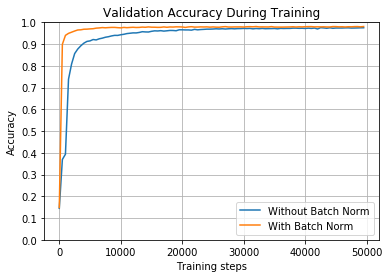

In [5]:
train_and_test(False, 0.01, tf.nn.relu)

As expected, both networks train well and eventually reach similar test accuracies. However, notice that the model with batch normalization converges slightly faster than the other network, reaching accuracies over 90% almost immediately and nearing its max acuracy in 10 or 15 thousand iterations. The other network takes about 3 thousand iterations to reach 90% and doesn't near its best accuracy until 30 thousand or more iterations.

If you look at the raw speed, you can see that without batch normalization we were computing over 1100 batches per second, whereas with batch normalization that goes down to just over 500. However, batch normalization allows us to perform fewer iterations and converge in less time over all. (We only trained for 50 thousand batches here so we could plot the comparison.)

**The following creates two networks with the same hyperparameters used in the previous example, but only trains for 2000 iterations.**

100%|██████████| 2000/2000 [00:03<00:00, 610.47it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.8482000231742859


100%|██████████| 2000/2000 [00:04<00:00, 406.32it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9535999894142151
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.842199981212616
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9521999955177307


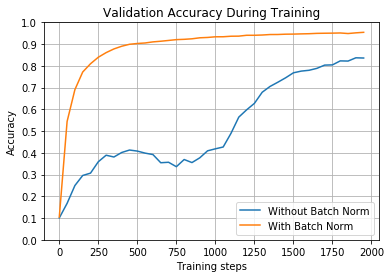

In [6]:
train_and_test(False, 0.01, tf.nn.relu, 2000, 50)

As you can see, using batch normalization produces a model with over 95% accuracy in only 2000 batches, and it was above 90% at somewhere around 500 batches. Without batch normalization, the model takes 1750 iterations just to hit 80% – the network with batch normalization hits that mark after around 200 iterations! (Note: if you run the code yourself, you'll see slightly different results each time because the starting weights - while the same for each model - are different for each run.)

In the above example, you should also notice that the networks trained fewer batches per second then what you saw in the previous example. That's because much of the time we're tracking is actually spent periodically performing inference to collect data for the plots. In this example we perform that inference every 50 batches instead of every 500, so generating the plot for this example requires 10 times the overhead for the same 2000 iterations.

**The following creates two networks using a sigmoid activation function, a learning rate of 0.01, and reasonable starting weights.**

100%|██████████| 50000/50000 [01:07<00:00, 742.91it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.8471999764442444


100%|██████████| 50000/50000 [01:44<00:00, 477.24it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9739999771118164
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.8388000130653381
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9725000262260437


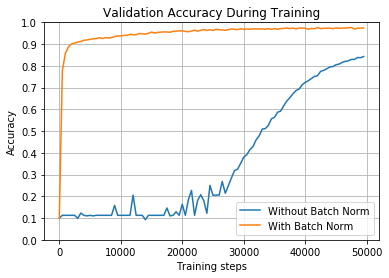

In [7]:
train_and_test(False, 0.01, tf.nn.sigmoid)

With the number of layers we're using and this small learning rate, using a sigmoid activation function takes a long time to start learning. It eventually starts making progress, but it took over 45 thousand batches just to get over 80% accuracy. Using batch normalization gets to 90% in around one thousand batches. 

**The following creates two networks using a ReLU activation function, a learning rate of 1, and reasonable starting weights.**

100%|██████████| 50000/50000 [01:01<00:00, 815.34it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|██████████| 50000/50000 [01:54<00:00, 437.58it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9832000136375427
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9815999865531921


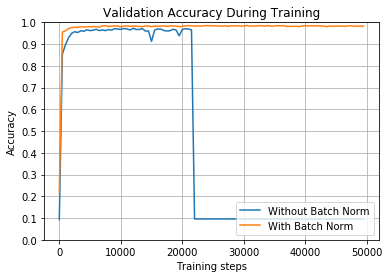

In [8]:
train_and_test(False, 1, tf.nn.relu)

Now we're using ReLUs again, but with a larger learning rate. The plot shows how training started out pretty normally, with the network with batch normalization starting out faster than the other. But the higher learning rate bounces the accuracy around a bit more, and at some point the accuracy in the network without batch normalization just completely crashes. It's likely that too many ReLUs died off at this point because of the high learning rate.

The next cell shows the same test again. The network with batch normalization performs the same way, and the other suffers from the same problem again, but it manages to train longer before it happens.

100%|██████████| 50000/50000 [01:15<00:00, 658.08it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.09759999811649323


100%|██████████| 50000/50000 [01:45<00:00, 473.58it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9828000068664551
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.10320000350475311
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9819999933242798


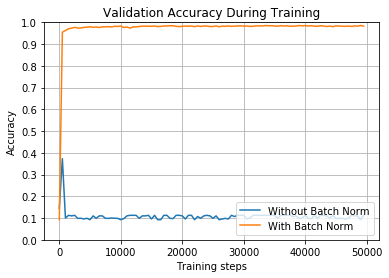

In [9]:
train_and_test(False, 1, tf.nn.relu)

In both of the previous examples, the network with batch normalization manages to gets over 98% accuracy, and get near that result almost immediately. The higher learning rate allows the network to train extremely fast.

**The following creates two networks using a sigmoid activation function, a learning rate of 1, and reasonable starting weights.**

100%|██████████| 50000/50000 [00:36<00:00, 1382.38it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9783996343612671


100%|██████████| 50000/50000 [01:35<00:00, 526.13it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9837996959686279
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9752001166343689
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.981200098991394


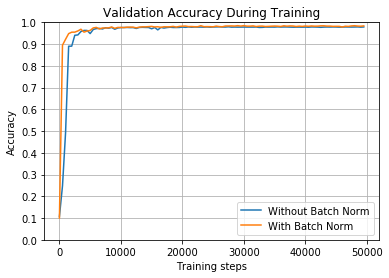

In [9]:
train_and_test(False, 1, tf.nn.sigmoid)

In this example, we switched to a sigmoid activation function. It appears to handle the higher learning rate well, with both networks achieving high accuracy.

The cell below shows a similar pair of networks trained for only 2000 iterations.

100%|██████████| 2000/2000 [00:01<00:00, 1167.28it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.920799732208252


100%|██████████| 2000/2000 [00:04<00:00, 490.92it/s]


With Batch Norm: After training, final accuracy on validation set = 0.951799750328064
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9227001070976257
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9463001489639282


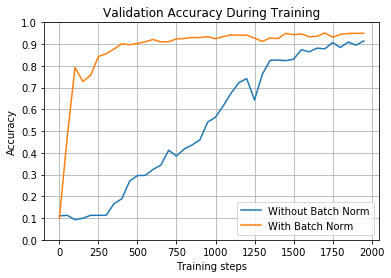

In [10]:
train_and_test(False, 1, tf.nn.sigmoid, 2000, 50)

As you can see, even though these parameters work well for both networks, the one with batch normalization gets over 90% in 400 or so batches, whereas the other takes over 1700. When training larger networks, these sorts of differences become more pronounced.

**The following creates two networks using a ReLU activation function, a learning rate of 2, and reasonable starting weights.**

100%|██████████| 50000/50000 [00:35<00:00, 1412.09it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.09859999269247055


100%|██████████| 50000/50000 [01:36<00:00, 518.06it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9827996492385864
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.10099999606609344
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9827001094818115


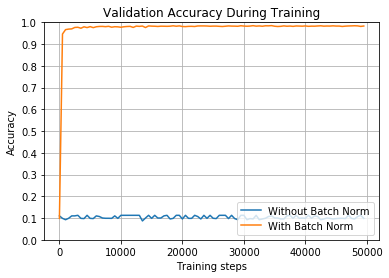

In [11]:
train_and_test(False, 2, tf.nn.relu)

With this very large learning rate, the network with batch normalization trains fine and almost immediately manages 98% accuracy. However, the network without normalization doesn't learn at all.

**The following creates two networks using a sigmoid activation function, a learning rate of 2, and reasonable starting weights.**

100%|██████████| 50000/50000 [00:35<00:00, 1395.37it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9795997142791748


100%|██████████| 50000/50000 [01:38<00:00, 506.05it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9803997278213501
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9782001376152039
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9782000780105591


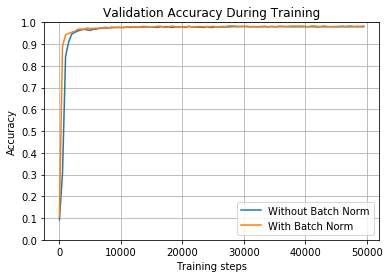

In [12]:
train_and_test(False, 2, tf.nn.sigmoid)

Once again, using a sigmoid activation function with the larger learning rate works well both with and without batch normalization.

However, look at the plot below where we train models with the same parameters but only 2000 iterations. As usual, batch normalization lets it train faster. 

100%|██████████| 2000/2000 [00:01<00:00, 1170.27it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9383997917175293


100%|██████████| 2000/2000 [00:04<00:00, 495.04it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9573997259140015
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9360001087188721
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9524001479148865


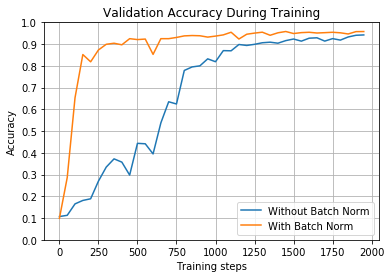

In [13]:
train_and_test(False, 2, tf.nn.sigmoid, 2000, 50)

In the rest of the examples, we use really bad starting weights. That is, normally we would use very small values close to zero. However, in these examples we choose random values with a standard deviation of 5. If you were really training a neural network, you would **not** want to do this. But these examples demonstrate how batch normalization makes your network much more resilient.  

**The following creates two networks using a ReLU activation function, a learning rate of 0.01, and bad starting weights.**

100%|██████████| 50000/50000 [00:43<00:00, 1147.21it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|██████████| 50000/50000 [01:37<00:00, 515.05it/s]


With Batch Norm: After training, final accuracy on validation set = 0.7945998311042786
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799998998641968
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.7990000247955322


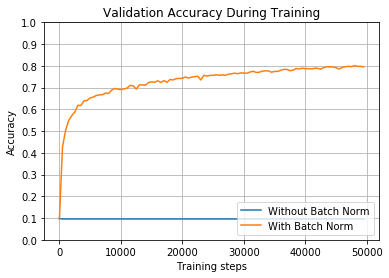

In [14]:
train_and_test(True, 0.01, tf.nn.relu)

As the plot shows, without batch normalization the network never learns anything at all. But with batch normalization, it actually learns pretty well and gets to almost 80% accuracy. The starting weights obviously hurt the network, but you can see how well batch normalization does in overcoming them. 

**The following creates two networks using a sigmoid activation function, a learning rate of 0.01, and bad starting weights.**

100%|██████████| 50000/50000 [00:45<00:00, 1108.50it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.22019998729228973


100%|██████████| 50000/50000 [01:34<00:00, 531.21it/s]


With Batch Norm: After training, final accuracy on validation set = 0.8591998219490051
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.22699999809265137
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.8527000546455383


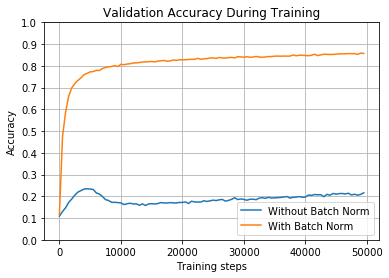

In [15]:
train_and_test(True, 0.01, tf.nn.sigmoid)

Using a sigmoid activation function works better than the ReLU in the previous example, but without batch normalization it would take a tremendously long time to train the network, if it ever trained at all. 

**The following creates two networks using a ReLU activation function, a learning rate of 1, and bad starting weights.**<a id="successful_example_lr_1"></a>

100%|██████████| 50000/50000 [00:38<00:00, 1313.14it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.11259999126195908


100%|██████████| 50000/50000 [01:36<00:00, 520.39it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9243997931480408
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.11349999904632568
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9208000302314758


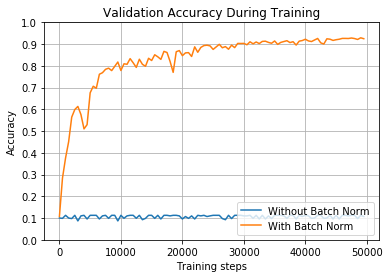

In [16]:
train_and_test(True, 1, tf.nn.relu)

The higher learning rate used here allows the network with batch normalization to surpass 90% in about 30 thousand batches. The network without it never gets anywhere.

**The following creates two networks using a sigmoid activation function, a learning rate of 1, and bad starting weights.**

100%|██████████| 50000/50000 [00:35<00:00, 1409.45it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.896999716758728


100%|██████████| 50000/50000 [01:33<00:00, 534.39it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9569997787475586
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.8957001566886902
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9505001306533813


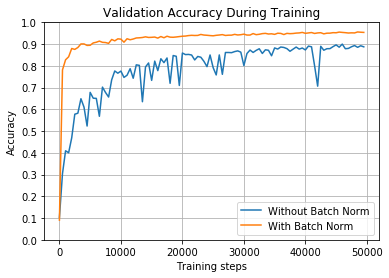

In [17]:
train_and_test(True, 1, tf.nn.sigmoid)

Using sigmoid works better than ReLUs for this higher learning rate. However, you can see that without batch normalization, the network takes a long time tro train, bounces around a lot, and spends a long time stuck at 90%. The network with batch normalization trains much more quickly, seems to be more stable, and achieves a higher accuracy.

**The following creates two networks using a ReLU activation function, a learning rate of 2, and bad starting weights.**<a id="successful_example_lr_2"></a>

100%|██████████| 50000/50000 [00:35<00:00, 1392.83it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|██████████| 50000/50000 [01:33<00:00, 536.51it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9127997159957886
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09800000488758087
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9054000973701477


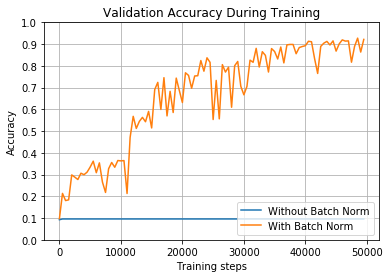

In [18]:
train_and_test(True, 2, tf.nn.relu)

We've already seen that ReLUs do not do as well as sigmoids with higher learning rates, and here we are using an extremely high rate. As expected, without batch normalization the network doesn't learn at all. But with batch normalization, it eventually achieves 90% accuracy. Notice, though, how its accuracy bounces around wildly during training - that's because the learning rate is really much too high, so the fact that this worked at all is a bit of luck.

**The following creates two networks using a sigmoid activation function, a learning rate of 2, and bad starting weights.**

100%|██████████| 50000/50000 [00:35<00:00, 1401.19it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9093997478485107


100%|██████████| 50000/50000 [01:33<00:00, 532.22it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9613996744155884
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9066000580787659
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9583001136779785


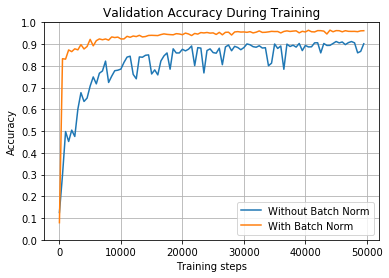

In [19]:
train_and_test(True, 2, tf.nn.sigmoid)

In this case, the network with batch normalization trained faster and reached a higher accuracy. Meanwhile, the high learning rate makes the network without normalization bounce around erratically and have trouble getting past 90%.

### Full Disclosure: Batch Normalization Doesn't Fix Everything

Batch normalization isn't magic and it doesn't work every time. Weights are still randomly initialized and batches are chosen at random during training, so you never know exactly how training will go. Even for these tests, where we use the same initial weights for both networks, we still get _different_ weights each time we run.

This section includes two examples that show runs when batch normalization did not help at all.

**The following creates two networks using a ReLU activation function, a learning rate of 1, and bad starting weights.**

100%|██████████| 50000/50000 [00:36<00:00, 1386.17it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.11259999126195908


100%|██████████| 50000/50000 [01:35<00:00, 523.58it/s]


With Batch Norm: After training, final accuracy on validation set = 0.09879998862743378
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.11350000649690628
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.10099999606609344


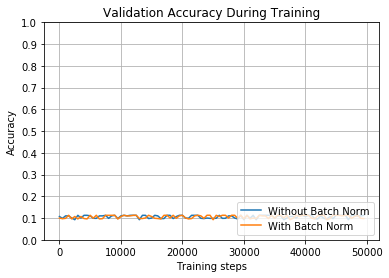

In [20]:
train_and_test(True, 1, tf.nn.relu)

When we used these same parameters [earlier](#successful_example_lr_1), we saw the network with batch normalization reach 92% validation accuracy. This time we used different starting weights, initialized using the same standard deviation as before, and the network doesn't learn at all. (Remember, an accuracy around 10% is what the network gets if it just guesses the same value all the time.)

**The following creates two networks using a ReLU activation function, a learning rate of 2, and bad starting weights.**

100%|██████████| 50000/50000 [00:35<00:00, 1398.39it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|██████████| 50000/50000 [01:34<00:00, 529.50it/s]


With Batch Norm: After training, final accuracy on validation set = 0.09859999269247055
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799998998641968
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.10100000351667404


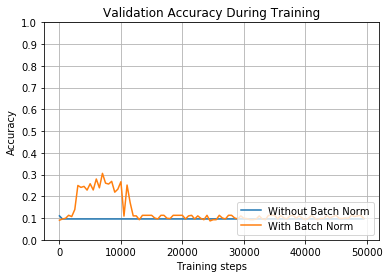

In [21]:
train_and_test(True, 2, tf.nn.relu)

When we trained with these parameters and batch normalization [earlier](#successful_example_lr_2), we reached 90% validation accuracy. However, this time the network _almost_ starts to make some progress in the beginning, but it quickly breaks down and stops learning. 

**Note:** Both of the above examples use *extremely* bad starting weights, along with learning rates that are too high. While we've shown batch normalization _can_ overcome bad values, we don't mean to encourage actually using them. The examples in this notebook are meant to show that batch normalization can help your networks train better. But these last two examples should remind you that you still want to try to use good network design choices and reasonable starting weights. It should also remind you that the results of each attempt to train a network are a bit random, even when using otherwise identical architectures.

# Batch Normalization: A Detailed Look<a id='implementation_2'></a>

The layer created by `tf.layers.batch_normalization` handles all the details of implementing batch normalization. Many students will be fine just using that and won't care about what's happening at the lower levels. However, some students may want to explore the details, so here is a short explanation of what's really happening, starting with the equations you're likely to come across if you ever read about batch normalization. 

In order to normalize the values, we first need to find the average value for the batch. If you look at the code, you can see that this is not the average value of the batch _inputs_, but the average value coming _out_ of any particular layer before we pass it through its non-linear activation function and then feed it as an input to the _next_ layer.

We represent the average as $\mu_B$, which is simply the sum of all of the values $x_i$ divided by the number of values, $m$ 

$$
\mu_B \leftarrow \frac{1}{m}\sum_{i=1}^m x_i
$$

We then need to calculate the variance, or mean squared deviation, represented as $\sigma_{B}^{2}$. If you aren't familiar with statistics, that simply means for each value $x_i$, we subtract the average value (calculated earlier as $\mu_B$), which gives us what's called the "deviation" for that value. We square the result to get the squared deviation. Sum up the results of doing that for each of the values, then divide by the number of values, again $m$, to get the average, or mean, squared deviation.

$$
\sigma_{B}^{2} \leftarrow \frac{1}{m}\sum_{i=1}^m (x_i - \mu_B)^2
$$

Once we have the mean and variance, we can use them to normalize the values with the following equation. For each value, it subtracts the mean and divides by the (almost) standard deviation. (You've probably heard of standard deviation many times, but if you have not studied statistics you might not know that the standard deviation is actually the square root of the mean squared deviation.)

$$
\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_{B}^{2} + \epsilon}}
$$

Above, we said "(almost) standard deviation". That's because the real standard deviation for the batch is calculated by $\sqrt{\sigma_{B}^{2}}$, but the above formula adds the term epsilon, $\epsilon$, before taking the square root. The epsilon can be any small, positive constant - in our code we use the value `0.001`. It is there partially to make sure we don't try to divide by zero, but it also acts to increase the variance slightly for each batch. 

Why increase the variance? Statistically, this makes sense because even though we are normalizing one batch at a time, we are also trying to estimate the population distribution – the total training set, which itself an estimate of the larger population of inputs your network wants to handle. The variance of a population is higher than the variance for any sample taken from that population, so increasing the variance a little bit for each batch helps take that into account. 

At this point, we have a normalized value, represented as $\hat{x_i}$. But rather than use it directly, we multiply it by a gamma value, $\gamma$, and then add a beta value, $\beta$. Both $\gamma$ and $\beta$ are learnable parameters of the network and serve to scale and shift the normalized value, respectively. Because they are learnable just like weights, they give your network some extra knobs to tweak during training to help it learn the function it is trying to approximate.  

$$
y_i \leftarrow \gamma \hat{x_i} + \beta
$$

We now have the final batch-normalized output of our layer, which we would then pass to a non-linear activation function like sigmoid, tanh, ReLU, Leaky ReLU, etc. In the original batch normalization paper (linked in the beginning of this notebook), they mention that there might be cases when you'd want to perform the batch normalization _after_ the non-linearity instead of before, but it is difficult to find any uses like that in practice.

In `NeuralNet`'s implementation of `fully_connected`, all of this math is hidden inside the following line, where `linear_output` serves as the $x_i$ from the equations:
```python
batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
```
The next section shows you how to implement the math directly. 

### Batch normalization without the `tf.layers` package

Our implementation of batch normalization in `NeuralNet` uses the high-level abstraction [tf.layers.batch_normalization](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization), found in TensorFlow's [`tf.layers`](https://www.tensorflow.org/api_docs/python/tf/layers) package.

However, if you would like to implement batch normalization at a lower level, the following code shows you how.
It uses [tf.nn.batch_normalization](https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization) from TensorFlow's [neural net (nn)](https://www.tensorflow.org/api_docs/python/tf/nn) package.

**1)** You can replace the `fully_connected` function in the `NeuralNet` class with the below code and everything in `NeuralNet` will still work like it did before.

In [ ]:
def fully_connected(self, layer_in, initial_weights, activation_fn=None):
    """
    Creates a standard, fully connected layer. Its number of inputs and outputs will be
    defined by the shape of `initial_weights`, and its starting weight values will be
    taken directly from that same parameter. If `self.use_batch_norm` is True, this
    layer will include batch normalization, otherwise it will not. 
        
    :param layer_in: Tensor
        The Tensor that feeds into this layer. It's either the input to the network or the output
        of a previous layer.
    :param initial_weights: NumPy array or Tensor
        Initial values for this layer's weights. The shape defines the number of nodes in the layer.
        e.g. Passing in 3 matrix of shape (784, 256) would create a layer with 784 inputs and 256 
        outputs. 
    :param activation_fn: Callable or None (default None)
        The non-linearity used for the output of the layer. If None, this layer will not include 
        batch normalization, regardless of the value of `self.use_batch_norm`. 
        e.g. Pass tf.nn.relu to use ReLU activations on your hidden layers.
    """
    if self.use_batch_norm and activation_fn:
        # Batch normalization uses weights as usual, but does NOT add a bias term. This is because 
        # its calculations include gamma and beta variables that make the bias term unnecessary.
        weights = tf.Variable(initial_weights)
        linear_output = tf.matmul(layer_in, weights)

        num_out_nodes = initial_weights.shape[-1]

        # Batch normalization adds additional trainable variables: 
        # gamma (for scaling) and beta (for shifting).
        gamma = tf.Variable(tf.ones([num_out_nodes]))
        beta = tf.Variable(tf.zeros([num_out_nodes]))

        # These variables will store the mean and variance for this layer over the entire training set,
        # which we assume represents the general population distribution.
        # By setting `trainable=False`, we tell TensorFlow not to modify these variables during
        # back propagation. Instead, we will assign values to these variables ourselves. 
        pop_mean = tf.Variable(tf.zeros([num_out_nodes]), trainable=False)
        pop_variance = tf.Variable(tf.ones([num_out_nodes]), trainable=False)

        # Batch normalization requires a small constant epsilon, used to ensure we don't divide by zero.
        # This is the default value TensorFlow uses.
        epsilon = 1e-3

        def batch_norm_training():
            # Calculate the mean and variance for the data coming out of this layer's linear-combination step.
            # The [0] defines an array of axes to calculate over.
            batch_mean, batch_variance = tf.nn.moments(linear_output, [0])

            # Calculate a moving average of the training data's mean and variance while training.
            # These will be used during inference.
            # Decay should be some number less than 1. tf.layers.batch_normalization uses the parameter
            # "momentum" to accomplish this and defaults it to 0.99
            decay = 0.99
            train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
            train_variance = tf.assign(pop_variance, pop_variance * decay + batch_variance * (1 - decay))

            # The 'tf.control_dependencies' context tells TensorFlow it must calculate 'train_mean' 
            # and 'train_variance' before it calculates the 'tf.nn.batch_normalization' layer.
            # This is necessary because the those two operations are not actually in the graph
            # connecting the linear_output and batch_normalization layers, 
            # so TensorFlow would otherwise just skip them.
            with tf.control_dependencies([train_mean, train_variance]):
                return tf.nn.batch_normalization(linear_output, batch_mean, batch_variance, beta, gamma, epsilon)
 
        def batch_norm_inference():
            # During inference, use the our estimated population mean and variance to normalize the layer
            return tf.nn.batch_normalization(linear_output, pop_mean, pop_variance, beta, gamma, epsilon)

        # Use `tf.cond` as a sort of if-check. When self.is_training is True, TensorFlow will execute 
        # the operation returned from `batch_norm_training`; otherwise it will execute the graph
        # operation returned from `batch_norm_inference`.
        batch_normalized_output = tf.cond(self.is_training, batch_norm_training, batch_norm_inference)
            
        # Pass the batch-normalized layer output through the activation function.
        # The literature states there may be cases where you want to perform the batch normalization *after*
        # the activation function, but it is difficult to find any uses of that in practice.
        return activation_fn(batch_normalized_output)
    else:
        # When not using batch normalization, create a standard layer that multiplies
        # the inputs and weights, adds a bias, and optionally passes the result 
        # through an activation function.  
        weights = tf.Variable(initial_weights)
        biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
        linear_output = tf.add(tf.matmul(layer_in, weights), biases)
        return linear_output if not activation_fn else activation_fn(linear_output)


This version of `fully_connected` is much longer than the original, but once again has extensive comments to help you understand it. Here are some important points:

1. It explicitly creates variables to store gamma, beta, and the population mean and variance. These were all handled for us in the previous version of the function.
2. It initializes gamma to one and beta to zero, so they start out having no effect in this calculation: $y_i \leftarrow \gamma \hat{x_i} + \beta$. However, during training the network learns the best values for these variables using back propagation, just like networks normally do with weights.
3. Unlike gamma and beta, the variables for population mean and variance are marked as untrainable. That tells TensorFlow not to modify them during back propagation. Instead, the lines that call `tf.assign` are used to update these variables directly.
4. TensorFlow won't automatically run the `tf.assign` operations during training because it only evaluates operations that are required based on the connections it finds in the graph. To get around that, we add this line: `with tf.control_dependencies([train_mean, train_variance]):` before we run the normalization operation. This tells TensorFlow it needs to run those operations before running anything inside the `with` block. 
5. The actual normalization math is still mostly hidden from us, this time using [`tf.nn.batch_normalization`](https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization).
5. `tf.nn.batch_normalization` does not have a `training` parameter like `tf.layers.batch_normalization` did. However, we still need to handle training and inference differently, so we run different code in each case using the [`tf.cond`](https://www.tensorflow.org/api_docs/python/tf/cond) operation.
6. We use the [`tf.nn.moments`](https://www.tensorflow.org/api_docs/python/tf/nn/moments) function to calculate the batch mean and variance.

**2)** The current version of the `train` function in `NeuralNet` will work fine with this new version of `fully_connected`. However, it uses these lines to ensure population statistics are updated when using batch normalization: 
```python
if self.use_batch_norm:
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
else:
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
```
Our new version of `fully_connected` handles updating the population statistics directly. That means you can also simplify your code by replacing the above `if`/`else` condition with just this line:
```python
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
```

**3)** And just in case you want to implement every detail from scratch, you can replace this line in `batch_norm_training`:

```python
return tf.nn.batch_normalization(linear_output, batch_mean, batch_variance, beta, gamma, epsilon)
```
with these lines:
```python
normalized_linear_output = (linear_output - batch_mean) / tf.sqrt(batch_variance + epsilon)
return gamma * normalized_linear_output + beta
```
And replace this line in `batch_norm_inference`:
```python
return tf.nn.batch_normalization(linear_output, pop_mean, pop_variance, beta, gamma, epsilon)
```
with these lines:
```python
normalized_linear_output = (linear_output - pop_mean) / tf.sqrt(pop_variance + epsilon)
return gamma * normalized_linear_output + beta
```

As you can see in each of the above substitutions, the two lines of replacement code simply implement the following two equations directly. The first line calculates the following equation, with `linear_output` representing $x_i$ and `normalized_linear_output` representing $\hat{x_i}$: 

$$
\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_{B}^{2} + \epsilon}}
$$

And the second line is a direct translation of the following equation:

$$
y_i \leftarrow \gamma \hat{x_i} + \beta
$$

We still use the `tf.nn.moments` operation to implement the other two equations from earlier – the ones that calculate the batch mean and variance used in the normalization step. If you really wanted to do everything from scratch, you could replace that line, too, but we'll leave that to you.  

## Why the difference between training and inference?

In the original function that uses `tf.layers.batch_normalization`, we tell the layer whether or not the network is training by passing a value for its `training` parameter, like so:
```python
batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
```
And that forces us to provide a value for `self.is_training` in our `feed_dict`, like we do in this example from `NeuralNet`'s `train` function:
```python
session.run(train_step, feed_dict={self.input_layer: batch_xs, 
                                   labels: batch_ys, 
                                   self.is_training: True})
```
If you looked at the [low level implementation](#low_level_code), you probably noticed that, just like with `tf.layers.batch_normalization`, we need to do slightly different things during training and inference. But why is that?

First, let's look at what happens when we don't. The following function is similar to `train_and_test` from earlier, but this time we are only testing one network and instead of plotting its accuracy, we perform 200 predictions on test inputs, 1 input at at time. We can use the `test_training_accuracy` parameter to test the network in training or inference modes (the equivalent of passing `True` or `False` to the `feed_dict` for `is_training`).

In [22]:
def batch_norm_test(test_training_accuracy):
    """
    :param test_training_accuracy: bool
        If True, perform inference with batch normalization using batch mean and variance;
        if False, perform inference with batch normalization using estimated population mean and variance.
    """

    weights = [np.random.normal(size=(784,100), scale=0.05).astype(np.float32),
               np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
               np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
               np.random.normal(size=(100,10), scale=0.05).astype(np.float32)
              ]

    tf.reset_default_graph()

    # Train the model
    bn = NeuralNet(weights, tf.nn.relu, True)
 
    # First train the network
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        bn.train(sess, 0.01, 2000, 2000)

        bn.test(sess, test_training_accuracy=test_training_accuracy, include_individual_predictions=True)

In the following cell, we pass `True` for `test_training_accuracy`, which performs the same batch normalization that we normally perform **during training**.

In [23]:
batch_norm_test(True)

100%|██████████| 2000/2000 [00:03<00:00, 514.57it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9527996778488159
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9503000974655151
200 Predictions: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Accuracy on 200 samples: 0.05


As you can see, the network guessed the same value every time! But why? Because during training, a network with batch normalization adjusts the values at each layer based on the mean and variance **of that batch**. The "batches" we are using for these predictions have a single input each time, so their values _are_ the means, and their variances will always be 0. That means the network will normalize the values at any layer to zero. (Review the equations from before to see why a value that is equal to the mean would always normalize to zero.) So we end up with the same result for every input we give the network, because its the value the network produces when it applies its learned weights to zeros at every layer. 

**Note:** If you re-run that cell, you might get a different value from what we showed. That's because the specific weights the network learns will be different every time. But whatever value it is, it should be the same for all 200 predictions.

To overcome this problem, the network does not just normalize the batch at each layer. It also maintains an estimate of the mean and variance for the entire population. So when we perform inference, instead of letting it "normalize" all the values using their own means and variance, it uses the estimates of the population mean and variance that it calculated while training. 

So in the following example, we pass `False` for `test_training_accuracy`, which tells the network that we it want to perform inference with the population statistics it calculates during training.

In [24]:
batch_norm_test(False)

100%|██████████| 2000/2000 [00:03<00:00, 511.58it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9577997326850891
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.953700065612793
200 Predictions: [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 8, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 4, 9, 8, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2]
Accuracy on 200 samples: 0.97


As you can see, now that we're using the estimated population mean and variance, we get a 97% accuracy. That means it guessed correctly on 194 of the 200 samples – not too bad for something that trained in under 4 seconds. :)

# Considerations for other network types

This notebook demonstrates batch normalization in a standard neural network with fully connected layers. You can also use batch normalization in other types of networks, but there are some special considerations.

### ConvNets

Convolution layers consist of multiple feature maps. (Remember, the depth of a convolutional layer refers to its number of feature maps.) And the weights for each feature map are shared across all the inputs that feed into the layer. Because of these differences, batch normalizaing convolutional layers requires batch/population mean and variance per feature map rather than per node in the layer.

When using `tf.layers.batch_normalization`, be sure to pay attention to the order of your convolutional dimensions.
Specifically, you may want to set a different value for the `axis` parameter if your layers have their channels first instead of last. 

In our low-level implementations, we used the following line to calculate the batch mean and variance:
```python
batch_mean, batch_variance = tf.nn.moments(linear_output, [0])
```
If we were dealing with a convolutional layer, we would calculate the mean and variance with a line like this instead:
```python
batch_mean, batch_variance = tf.nn.moments(conv_layer, [0,1,2], keep_dims=False)
```
The second parameter, `[0,1,2]`, tells TensorFlow to calculate the batch mean and variance over each feature map. (The three axes are the batch, height, and width.) And setting `keep_dims` to `False` tells `tf.nn.moments` not to return values with the same size as the inputs. Specifically, it ensures we get one mean/variance pair per feature map.

### RNNs

Batch normalization can work with recurrent neural networks, too, as shown in the 2016 paper [Recurrent Batch Normalization](https://arxiv.org/abs/1603.09025). It's a bit more work to implement, but basically involves calculating the means and variances per time step instead of per layer. You can find an example where someone extended `tf.nn.rnn_cell.RNNCell` to include batch normalization in [this GitHub repo](https://gist.github.com/spitis/27ab7d2a30bbaf5ef431b4a02194ac60).